In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append("D:\\Matsuura\\lib")
sys.path.append("D:\\Matsuura\\lib\\sequence_parser")
sys.path.append("D:\\Matsuura\\lib\\sqe_fitting")
sys.path.append("D:\\Matsuura\\lib\\qcodes_drivers")
sys.path.append("D:\\Matsuura\\lib\\measurement_codes_ut")

In [3]:
from plottr.data.datadict_storage import datadict_from_hdf5
from plottr.data.datadict_storage import DataDict, DDH5Writer
import numpy as np
import matplotlib.pyplot as plt
import os
from pprint import pprint
from tqdm import tqdm

# Create session

In [4]:
from measurement_tool.session import SessionManager as Session
from measurement_tool.datataking.time_domain_temp import TimeDomainInstrumentManager as TDM

In [5]:
session = Session(
    cooling_down_id='CDY131', 
    experiment_username="Matsuura", 
    sample_name="NLR2-45D")

# Create TDM - instrument manager

In [6]:
tdm = TDM(session, trigger_address="PXI0::1::BACKPLANE")

Creating a new insturment management class for timedomain measurement...done


## Set wiring information text

In [7]:
wiring = "\n".join([
    "readout",
    "E8257D(lo1) - 1500mm - LO2",
    "M3202A_slot2_ch1 - 500mm - 10dB - IFin2",
    "RFout2 - 1000mm - 20dB - F-19480 - In1D",
    "Out2A - Miteq - 1500mm - RFin1",
    "IFout1 - 500mm - DCblock - M3102A_slot9_ch1",

    "drive_line",
    "N5173B - 2000mm - LO#4",
    "M3202A_slot2_ch2 - 500mm - 10dB - IFin4",
    "RFout#4 - 1500mm - 10dB - In1C"
])

tdm.set_wiring_note(wiring)

## Add control line information

In [8]:
# For readout line
tdm.add_readout_line(
    port_name="readout",
    lo_address="TCPIP0::192.168.100.5::inst0::INSTR",
    lo_power=24,
    awg_chasis=1,
    awg_slot=2,
    awg_channel=1,
    dig_chasis=1,
    dig_slot=9,
    dig_channel=1,
    IQ_corrector=None,
    if_freq=125e6,
)

# For qubit control line
tdm.add_qubit_line(
    port_name="qubit",
    lo_address="TCPIP0::192.168.100.9::inst0::INSTR",
    lo_power=18,
    awg_chasis=1,
    awg_slot=2,
    awg_channel=2,
    IQ_corrector=None,
    if_freq=150e6,
)

# # Current source
# tdm.add_current_source_bias_line(
#     port_name='readout_bias', 
#     current_source_address="TCPIP0::192.168.100.96::inst0::INSTR"
# )

# You can also use add_misc_control_line for e-f, fogi, cloaking etc.

Connected to: Agilent Technologies N5173B (serial:MY59100372, firmware:B.01.80) in 0.03s


In [9]:
# tdm.current_source['readout_bias'].ramp_current(123e-6, step=1e-7, delay=0)

In [10]:
print(tdm)

*** Allocated devices and channel assignemnt ***
device type          device name          device address                           channel                        port           
-----------------------------------------------------------------------------------------------------------------------------
LO                   E8257D               TCPIP0::192.168.100.5::inst0::INSTR                                     readout        
LO                   N5173B               TCPIP0::192.168.100.9::inst0::INSTR                                     qubit          
AWG                  M3202A                                                        chasis1 slot2 ch1              readout        
AWG                  M3202A                                                        chasis1 slot2 ch2              qubit          
Digitizer            M3102A                                                        chasis1 slot9 ch1              readout        
HVI trigger          M3601A               PXI

# Main

## Initialize calibration note

In [11]:
from measurement_tool import CalibrationNote
note = CalibrationNote()
note.set_initial_value("pi_pulse_length",40)
note.set_initial_value("cavity_dressed_frequency_cw", 9.24e9)
note.set_initial_value("cavity_dressed_frequency_linewidth_cw", 5e6)
note.set_initial_value("qubit_frequency_cw", 8.02e9)

## Experiments

In [12]:
tdm.lo, tdm.awg, tdm.digitizer, tdm.hvi_trigger, tdm.current_source

({'readout': <E82x7: lo_0>, 'qubit': <N51x1: lo_1>},
 {0: <M3202A: awg_0>},
 {'readout': <M3102A: dig_0>},
 <HVI_Trigger: hvi_trigger>,
 {})

100%|██████████| 2/2 [00:00<00:00,  4.23it/s]


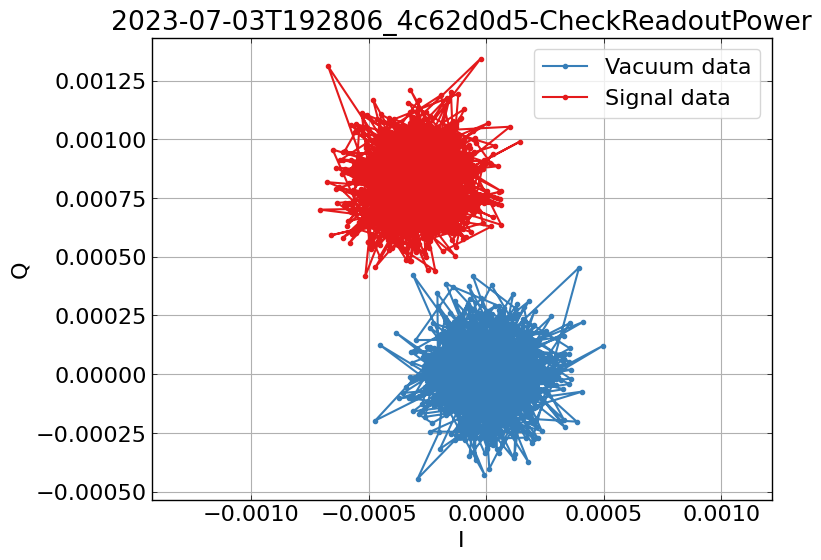

cavity_dressed_frequency_cw : 9240000000.0
cavity_readout_sequence_amplitude_expected_sn : 0.7244270876118369



In [13]:
from measurement_codes_ut.experiment.time_domain.check_readout_power import CheckReadoutPower

exp = CheckReadoutPower(num_shot=1000, expected_sn_ratio=5, trial_amplitude=1)
dataset = exp.execute(tdm, note)
print(note)

100%|██████████| 1/1 [00:00<00:00,  2.91it/s]


Experiment data saved in D:/data_vault/Matsuura/2023-07-03/2023-07-03T192809_4e8d5c40-CheckReadoutDelay/


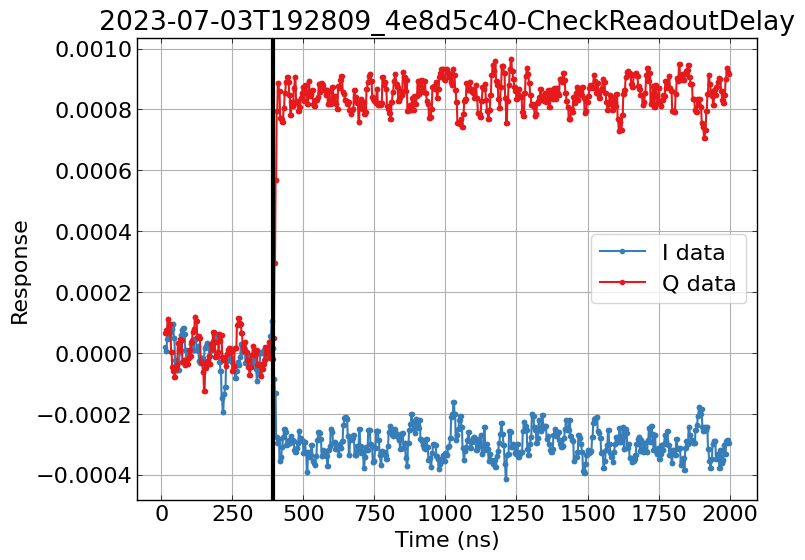

cavity_dressed_frequency_cw : 9240000000.0
cavity_readout_sequence_amplitude_expected_sn : 0.7244270876118369
cavity_readout_trigger_delay : 394.0



In [14]:
from measurement_codes_ut.experiment.time_domain.check_readout_delay import CheckReadoutDelay

exp = CheckReadoutDelay(num_shot=1000)
dataset = exp.execute(tdm, note)
print(note)

100%|██████████| 21/21 [00:02<00:00,  7.41it/s]


Experiment data saved in D:/data_vault/Matsuura/2023-07-03/2023-07-03T192811_4f561606-CheckElectricalDelay/


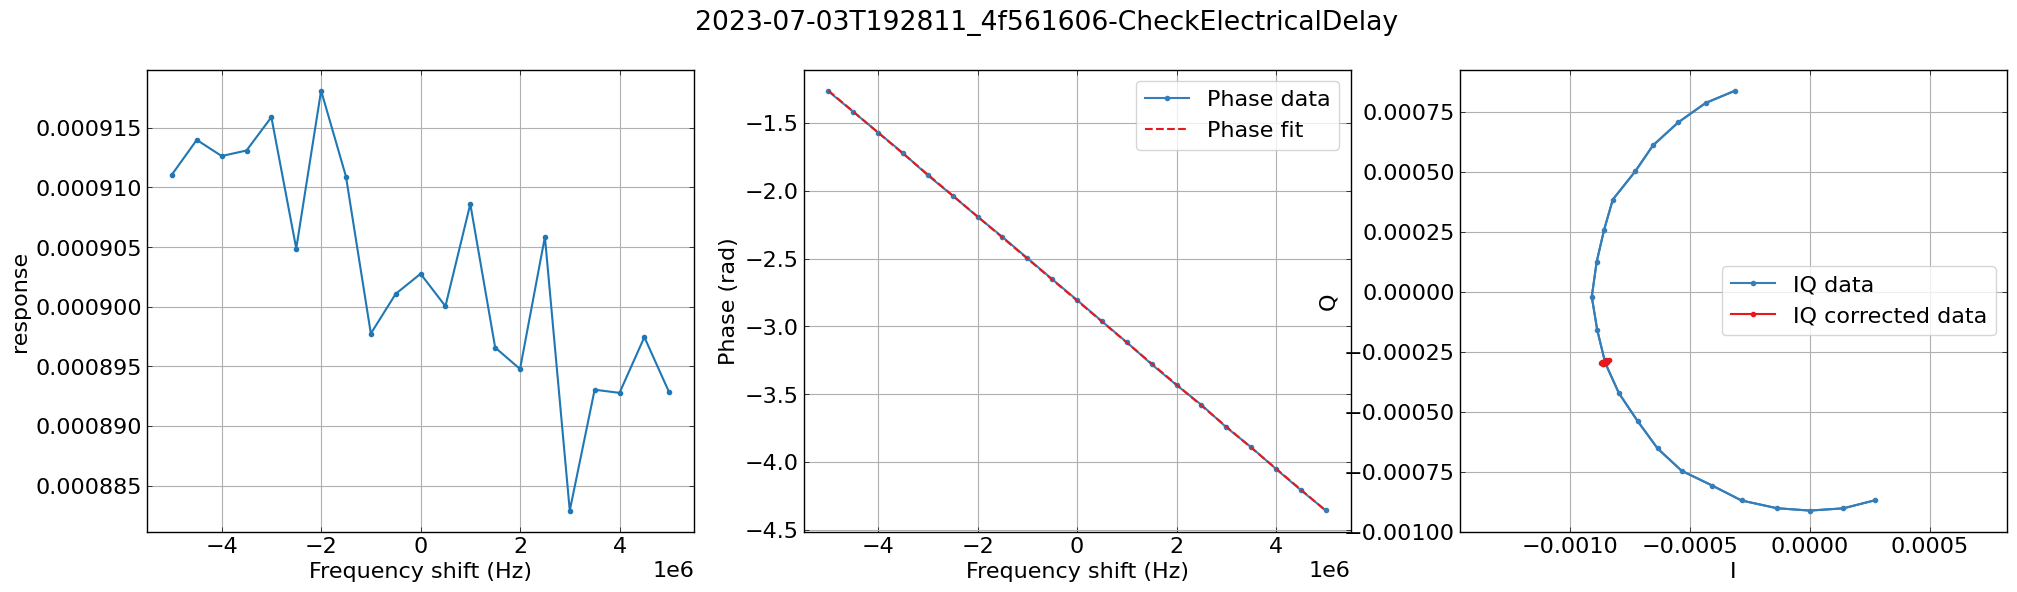

cavity_dressed_frequency_cw : 9240000000.0
cavity_readout_sequence_amplitude_expected_sn : 0.7244270876118369
cavity_readout_trigger_delay : 394.0
cavity_readout_electrical_delay : -4.9289200723463496e-08



In [15]:
from measurement_codes_ut.experiment.time_domain.check_electrical_delay import CheckElectricalDelay

exp = CheckElectricalDelay(num_shot=1000, sweep_range=10e6, sweep_step=21)
dataset = exp.execute(tdm, note)
print(note)

100%|██████████| 201/201 [00:26<00:00,  7.70it/s]


Experiment data saved in D:/data_vault/Matsuura/2023-07-03/2023-07-03T192815_5200763f-FindCavityPeak/


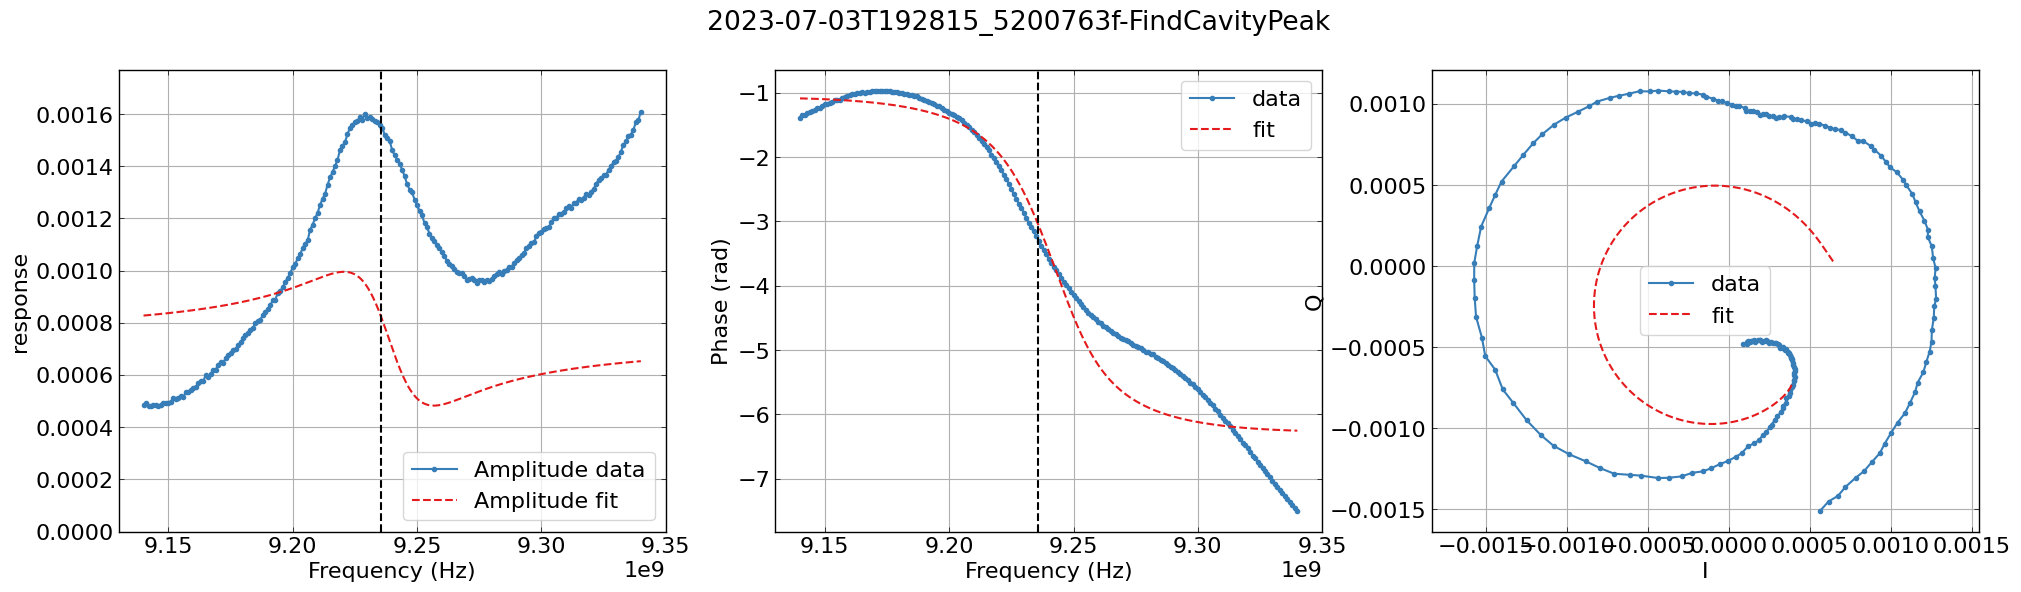

In [16]:
from measurement_codes_ut.experiment.time_domain.find_cavity_peak import FindCavityPeak

exp = FindCavityPeak(num_shot=1000, sweep_range=200e6, sweep_step=201)
dataset = exp.execute(tdm, note)

In [17]:
note.globals.cavity_dressed_frequency.value = 9.23e9

In [18]:
print(note)

cavity_dressed_frequency_cw : 9240000000.0
cavity_readout_sequence_amplitude_expected_sn : 0.7244270876118369
cavity_readout_trigger_delay : 394.0
cavity_readout_electrical_delay : -4.9289200723463496e-08
cavity_dressed_frequency_linewidth_cw : 5000000.0
cavity_dressed_frequency : 9230000000.0
cavity_dressed_frequency_linewidth : 35596866.50204261
cavity_external_decay_rate : 35596722.83195313
cavity_intrinsic_decay_rate : 143.6700894761506



100%|██████████| 101/101 [00:24<00:00,  4.21it/s]


Experiment data saved in D:/data_vault/Matsuura/2023-07-03/2023-07-03T192844_630a8e45-FindQubitPeak/


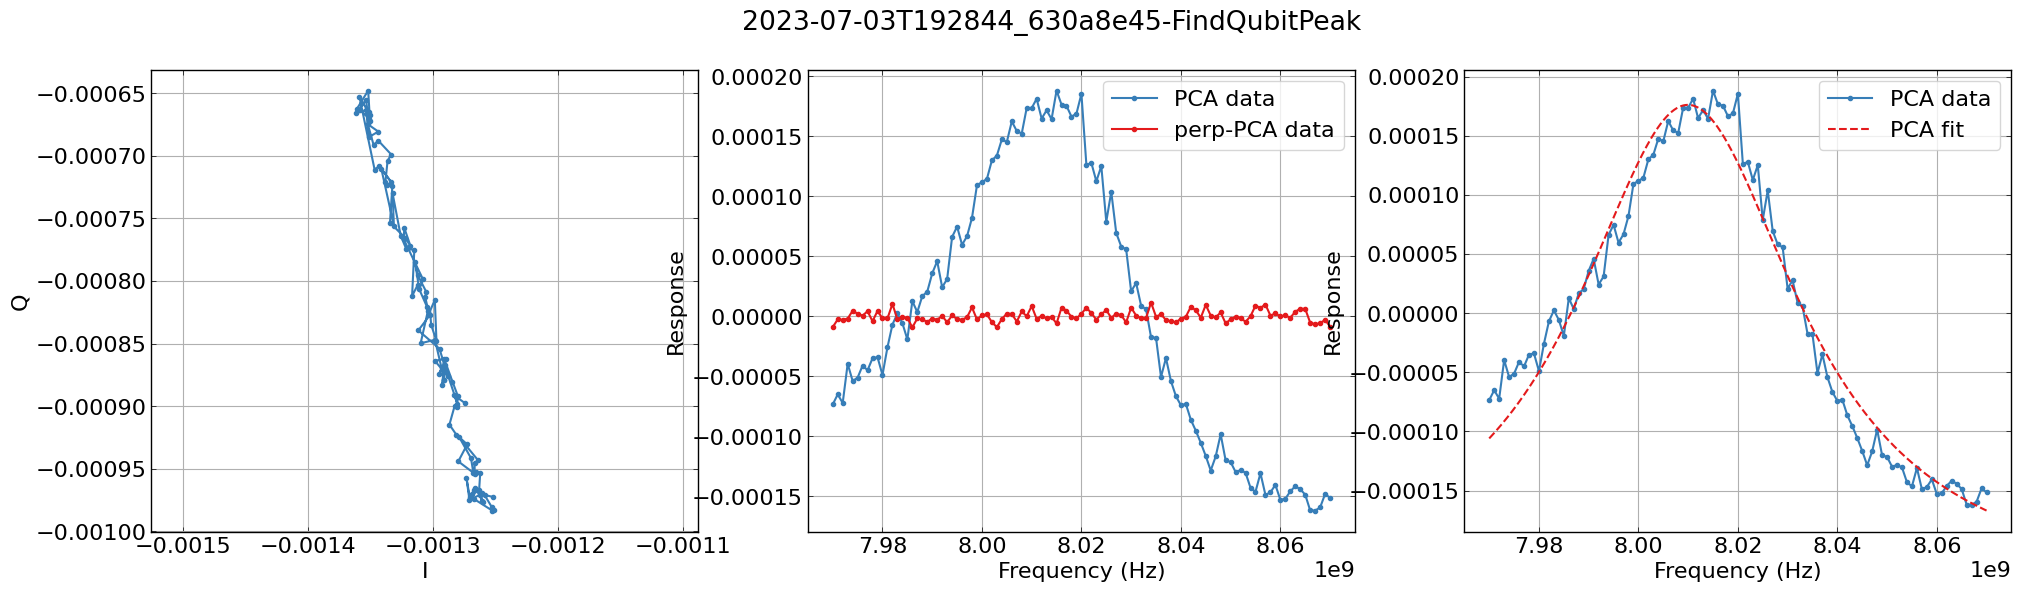

In [19]:
from measurement_codes_ut.experiment.time_domain.find_qubit_peak import FindQubitPeak

exp = FindQubitPeak(num_shot=1000, sweep_range=100e6, sweep_step=101, qubit_pump_amplitude=.25)
dataset = exp.execute(tdm, note)

In [20]:
print(note)

cavity_dressed_frequency_cw : 9240000000.0
cavity_readout_sequence_amplitude_expected_sn : 0.7244270876118369
cavity_readout_trigger_delay : 394.0
cavity_readout_electrical_delay : -4.9289200723463496e-08
cavity_dressed_frequency_linewidth_cw : 5000000.0
cavity_dressed_frequency : 9230000000.0
cavity_dressed_frequency_linewidth : 35596866.50204261
cavity_external_decay_rate : 35596722.83195313
cavity_intrinsic_decay_rate : 143.6700894761506
qubit_frequency_cw : 8020000000.0
qubit_dressed_frequency : 8009958074.958991
qubit_full_linewidth : 54726867.75896238
qubit_control_amplitude : 0.25



100%|██████████| 60/60 [00:16<00:00,  3.59it/s]


Experiment data saved in D:/data_vault/Matsuura/2023-07-03/2023-07-03T192910_72976fd4-CheckRabiOscillation/


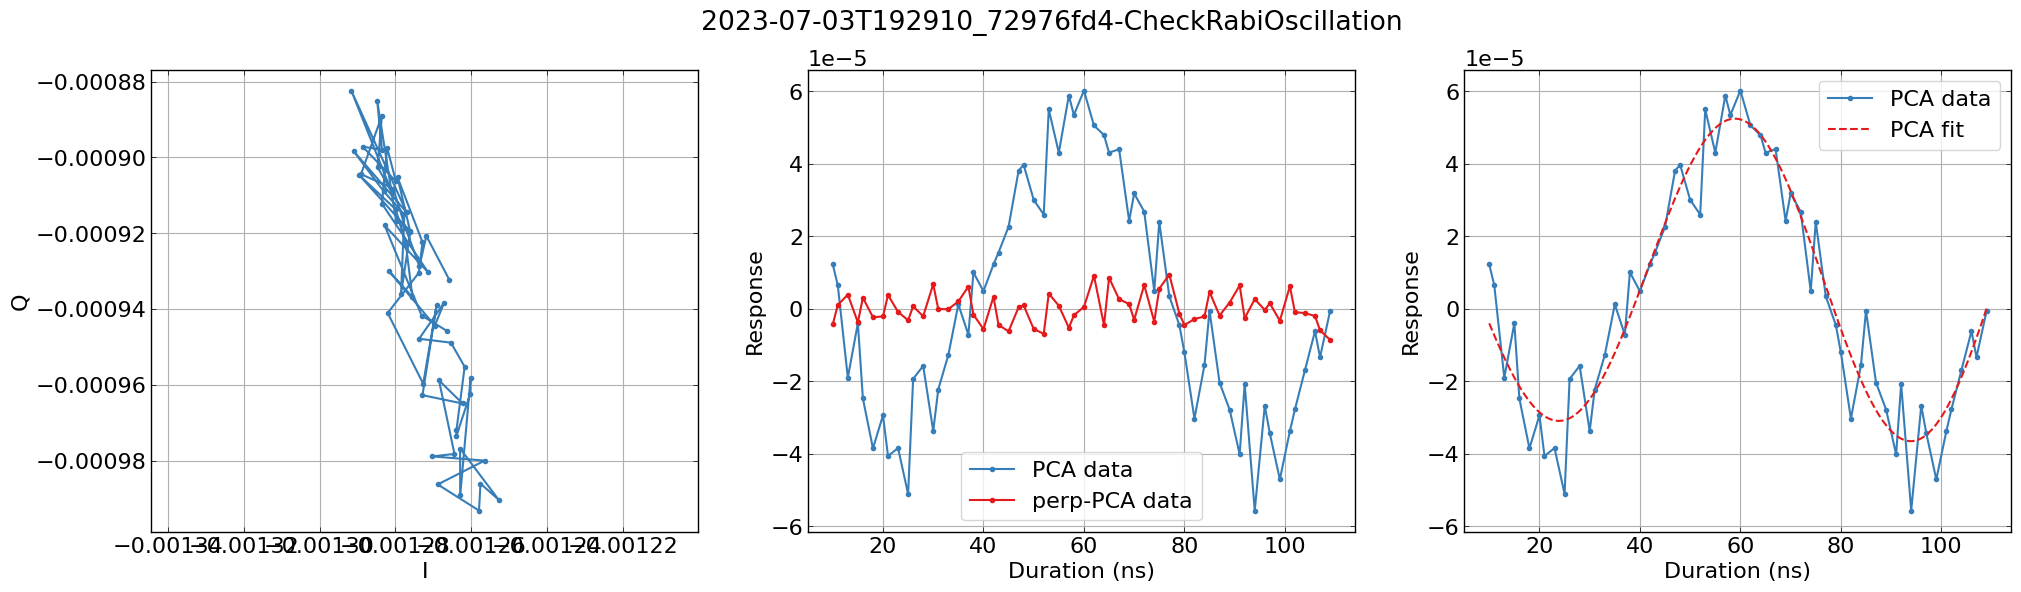

In [21]:
from measurement_codes_ut.experiment.time_domain.check_rabi_oscillation import CheckRabiOscillation

exp = CheckRabiOscillation(num_shot=1000, num_cycle=6, num_point_per_cycle=10)
dataset = exp.execute(tdm, note)

In [22]:
print(note)

cavity_dressed_frequency_cw : 9240000000.0
cavity_readout_sequence_amplitude_expected_sn : 0.7244270876118369
cavity_readout_trigger_delay : 394.0
cavity_readout_electrical_delay : -4.9289200723463496e-08
cavity_dressed_frequency_linewidth_cw : 5000000.0
cavity_dressed_frequency : 9230000000.0
cavity_dressed_frequency_linewidth : 35596866.50204261
cavity_external_decay_rate : 35596722.83195313
cavity_intrinsic_decay_rate : 143.6700894761506
qubit_frequency_cw : 8020000000.0
qubit_dressed_frequency : 8009958074.958991
qubit_full_linewidth : 54726867.75896238
qubit_control_amplitude : 0.25
rabi_frequency : 0.014270312068719211
rabi_decay_rate : -0.0018523139451941813
rabi_t1 : -539.8652871963171



100%|██████████| 41/41 [00:11<00:00,  3.59it/s]


Experiment data saved in D:/data_vault/Matsuura/2023-07-03/2023-07-03T192929_7ddc77f7-CreatePiPulse/


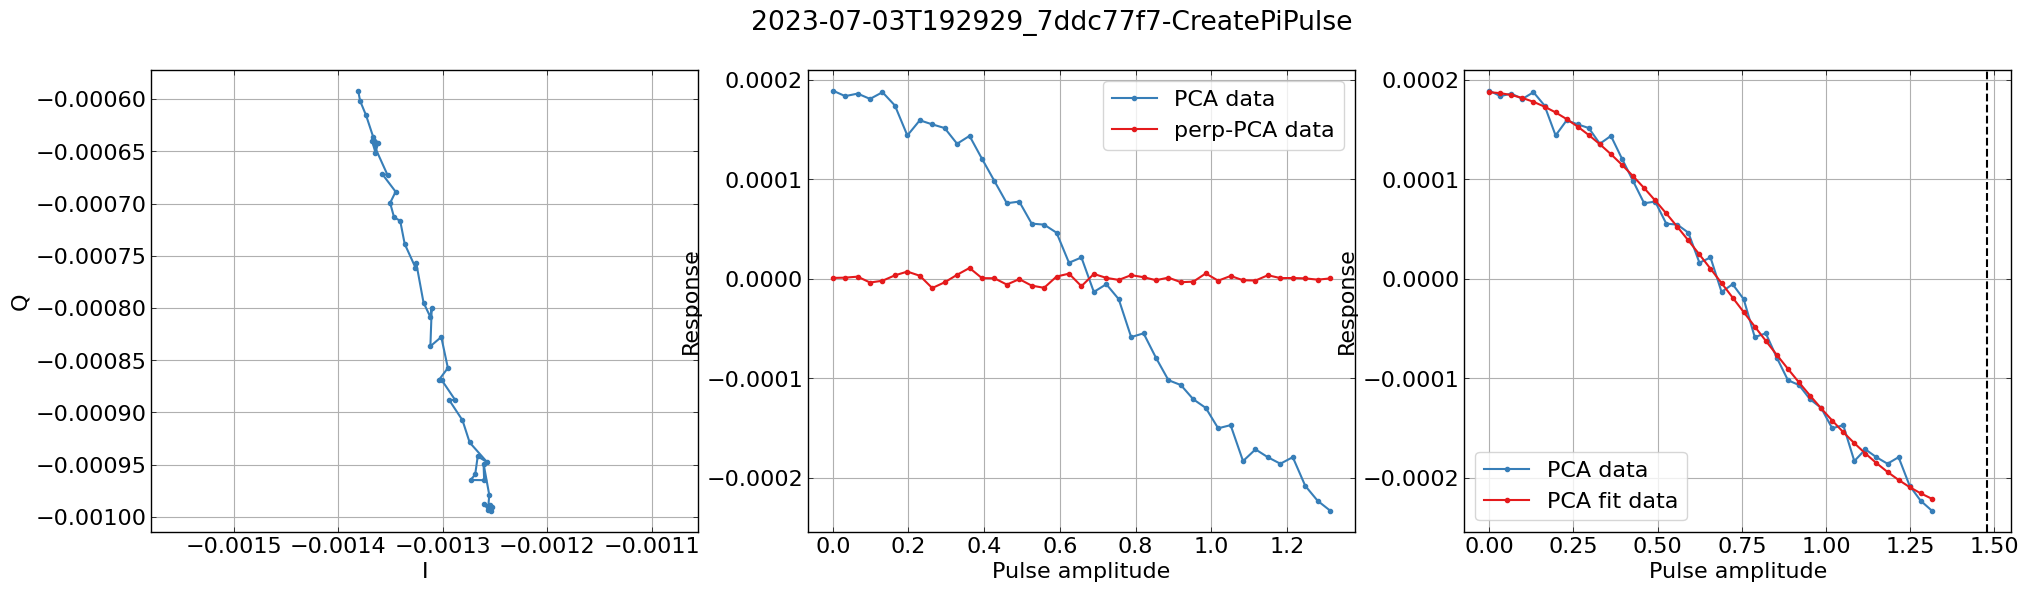

In [23]:
from measurement_codes_ut.experiment.time_domain.create_pi_pulse import CreatePiPulse

exp = CreatePiPulse(num_shot=1000, num_point=41)
dataset = exp.execute(tdm, note)

In [24]:
print(note)

cavity_dressed_frequency_cw : 9240000000.0
cavity_readout_sequence_amplitude_expected_sn : 0.7244270876118369
cavity_readout_trigger_delay : 394.0
cavity_readout_electrical_delay : -4.9289200723463496e-08
cavity_dressed_frequency_linewidth_cw : 5000000.0
cavity_dressed_frequency : 9230000000.0
cavity_dressed_frequency_linewidth : 35596866.50204261
cavity_external_decay_rate : 35596722.83195313
cavity_intrinsic_decay_rate : 143.6700894761506
qubit_frequency_cw : 8020000000.0
qubit_dressed_frequency : 8009958074.958991
qubit_full_linewidth : 54726867.75896238
qubit_control_amplitude : 0.25
rabi_frequency : 0.014270312068719211
rabi_decay_rate : -0.0018523139451941813
rabi_t1 : -539.8652871963171
pi_pulse_length : 40
pi_pulse_power : 1.4765466128002698



100%|██████████| 41/41 [00:11<00:00,  3.58it/s]


Experiment data saved in D:/data_vault/Matsuura/2023-07-03/2023-07-03T192942_859d33e3-FindDispersiveShift/


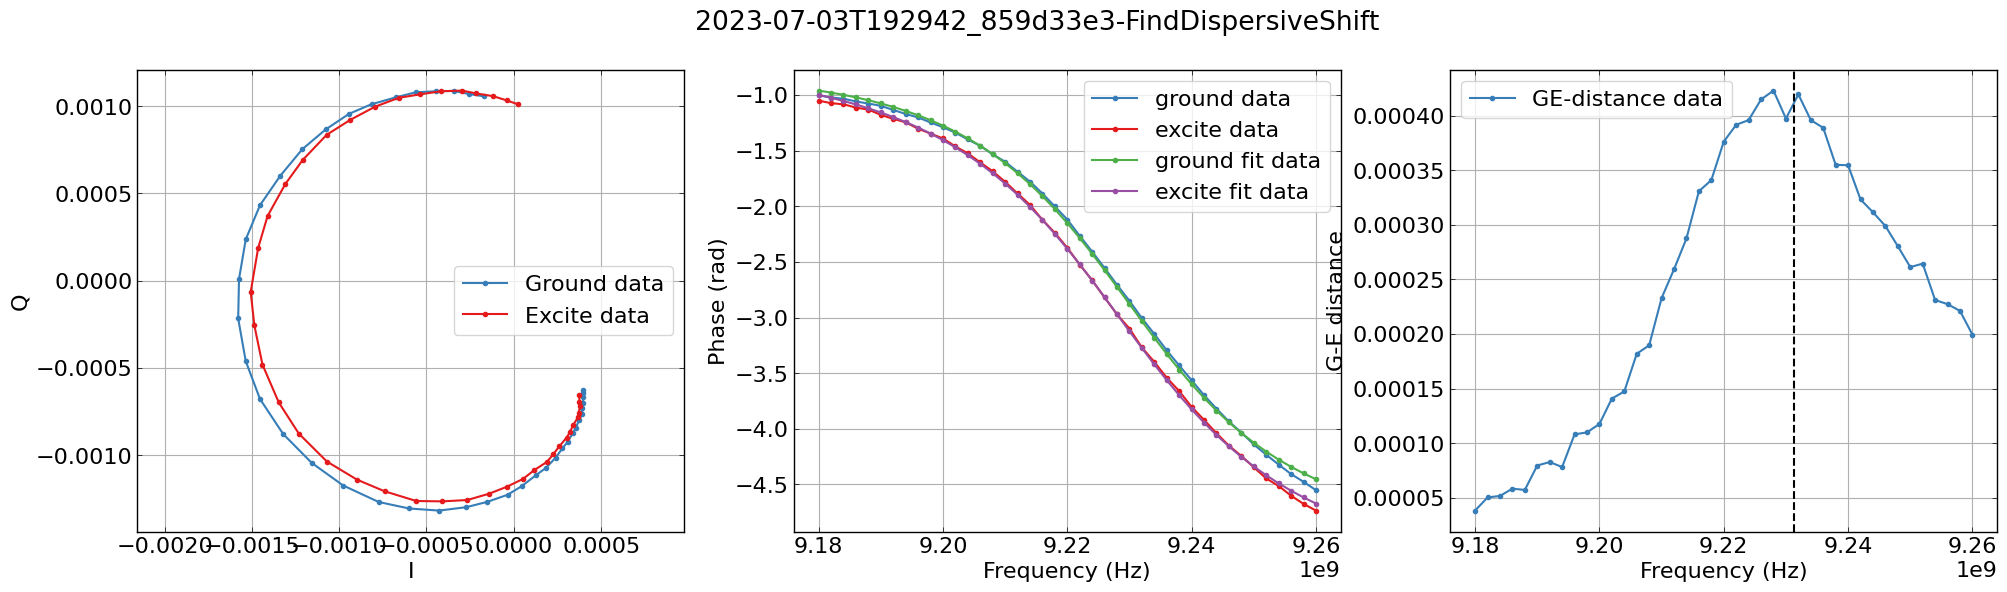

In [25]:
from measurement_codes_ut.experiment.time_domain.find_dispersive_shift import FindDispersiveShift

exp = FindDispersiveShift(num_shot=1000, sweep_range=80e6, sweep_offset=-10e6, num_step=41)
dataset = exp.execute(tdm, note)

100%|██████████| 20/20 [00:25<00:00,  1.30s/it]


Experiment data saved in D:/data_vault/Matsuura/2023-07-03/2023-07-03T193006_9444bf84-OptimizeReadoutPowerAndWindow/


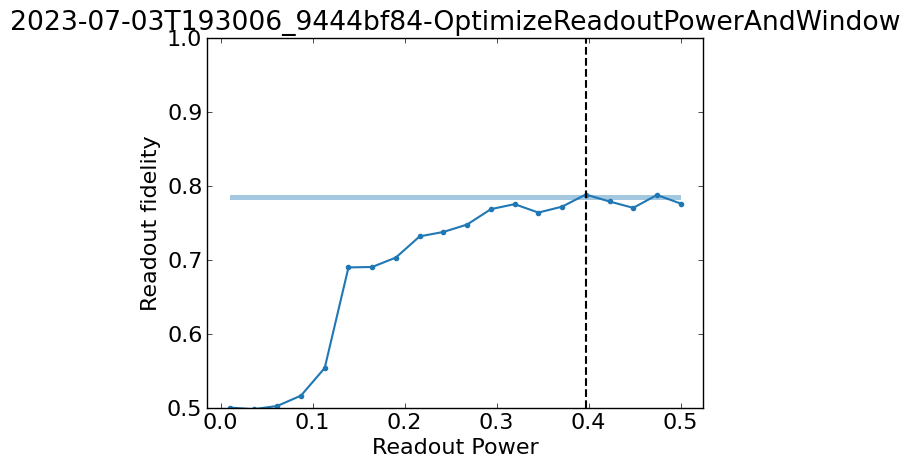

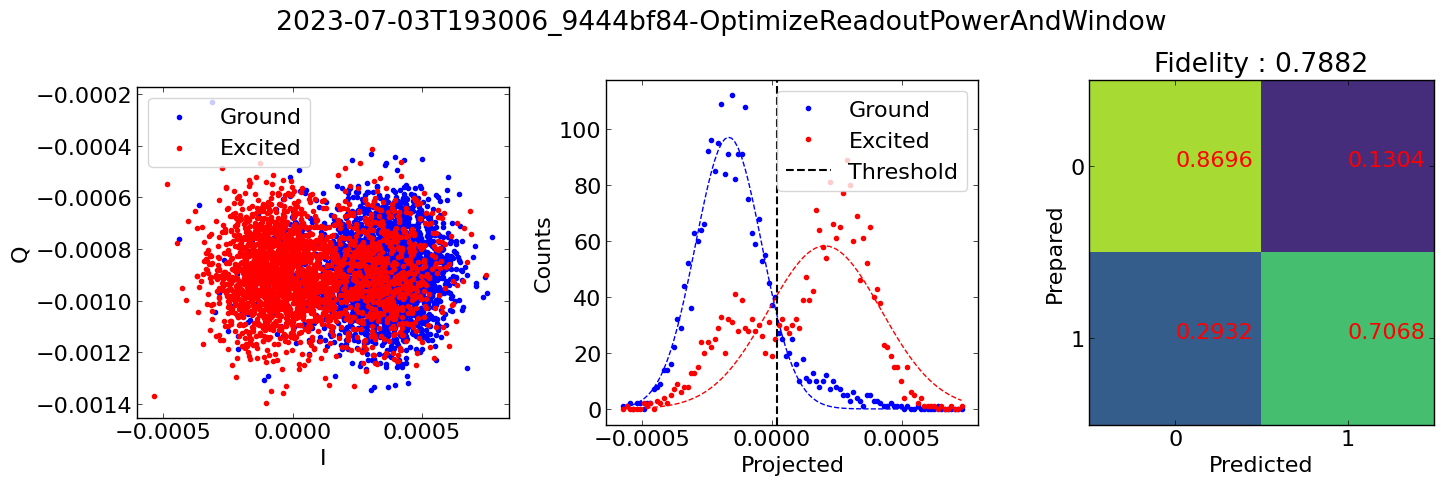

In [26]:
from measurement_codes_ut.experiment.time_domain.optimize_readout_power_and_window import OptimizeReadoutPowerAndWindow

exp = OptimizeReadoutPowerAndWindow(num_shot=2500, num_point=20, min_amplitude=0.01, max_amplitude=0.5, fidelity_fluctuate=0.01)
dataset = exp.execute(tdm, note)

100%|██████████| 50/50 [00:13<00:00,  3.62it/s]


Experiment data saved in D:/data_vault/Matsuura/2023-07-03/2023-07-03T193100_b3f0c16a-CheckXYRamsey/


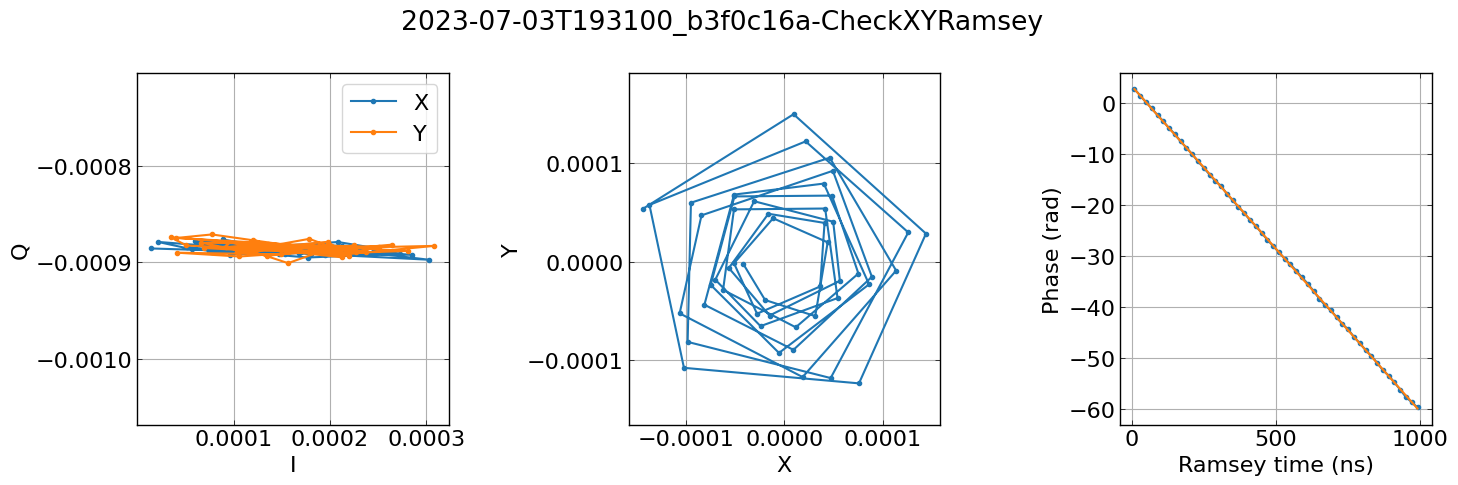

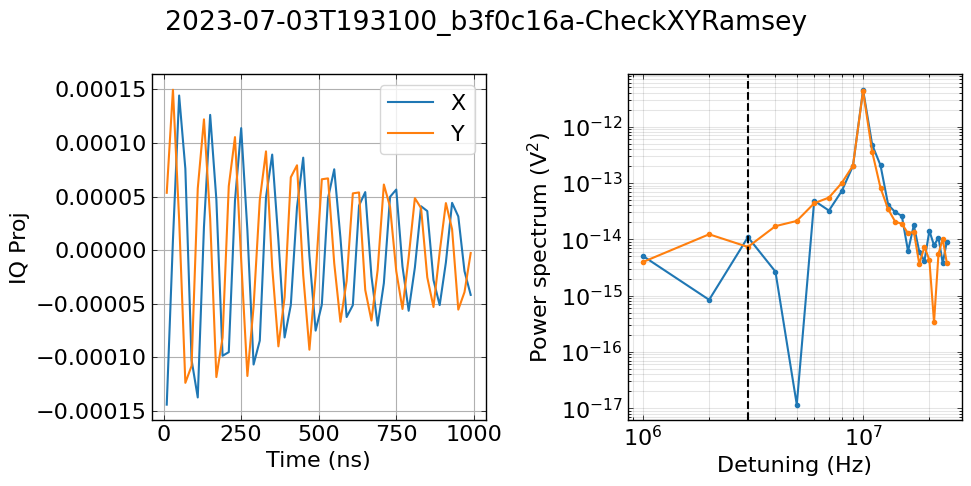

In [27]:

from measurement_codes_ut.experiment.time_domain.check_xy_ramsey import CheckXYRamsey

exp = CheckXYRamsey(num_shot=1000, min_duration=10, max_duration=1000, hand_detune=3e6)
dataset = exp.execute(tdm, note)

100%|██████████| 21/21 [00:05<00:00,  3.58it/s]


Experiment data saved in D:/data_vault/Matsuura/2023-07-03/2023-07-03T193130_c61093ad-CreatePiPulse/


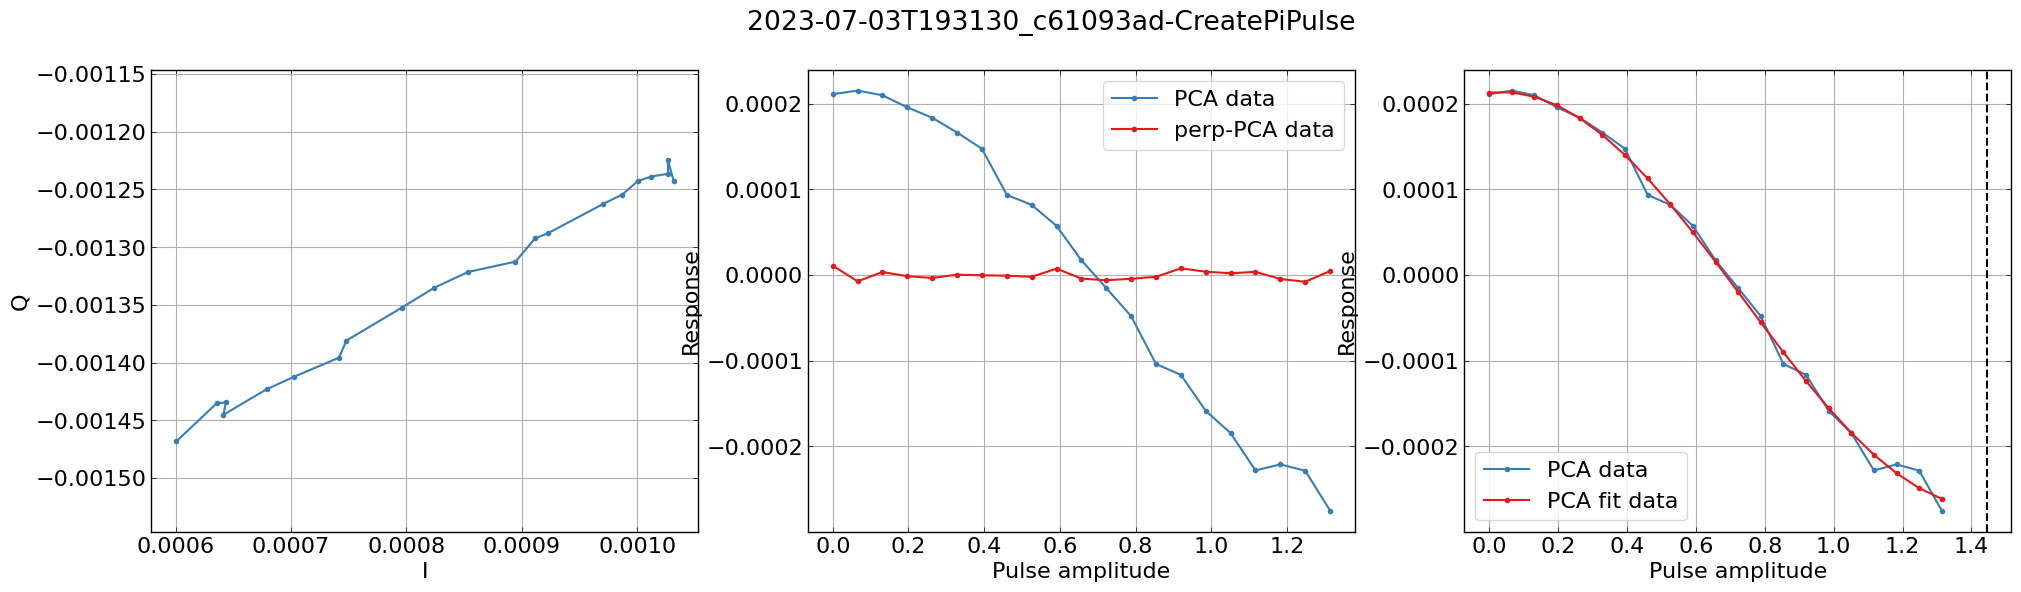

In [28]:
from measurement_codes_ut.experiment.time_domain.create_pi_pulse import CreatePiPulse

exp = CreatePiPulse(num_shot=1000, num_point=21)
dataset = exp.execute(tdm, note)

100%|██████████| 51/51 [00:14<00:00,  3.50it/s]


Experiment data saved in D:/data_vault/Matsuura/2023-07-03/2023-07-03T193137_ca37dc22-CheckT1Decay/


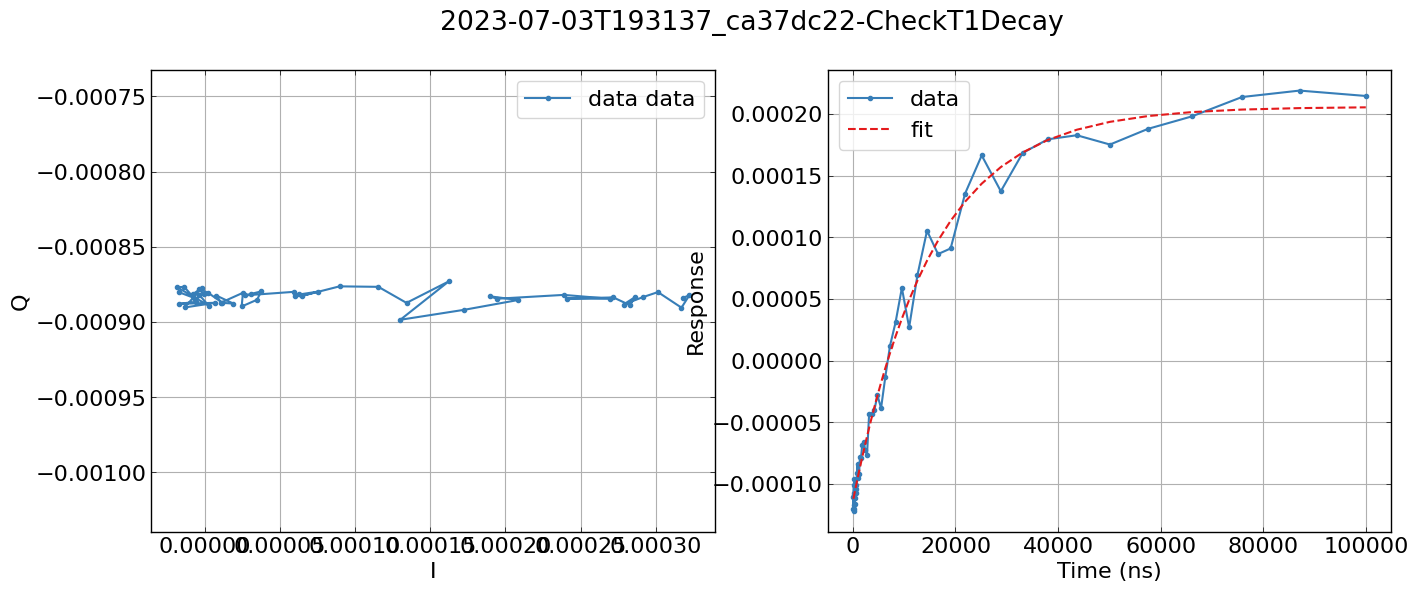

15356.092602267187


In [29]:
from measurement_codes_ut.experiment.time_domain.check_t1_decay import CheckT1Decay

exp = CheckT1Decay(num_shot=1000, min_duration=100, max_duration=100e3, num_sample=51)
dataset = exp.execute(tdm, note)
print(note.t1)

100%|██████████| 101/101 [00:28<00:00,  3.56it/s]


Experiment data saved in D:/data_vault/Matsuura/2023-07-03/2023-07-03T193153_d39353f0-CheckT2Ramsey/


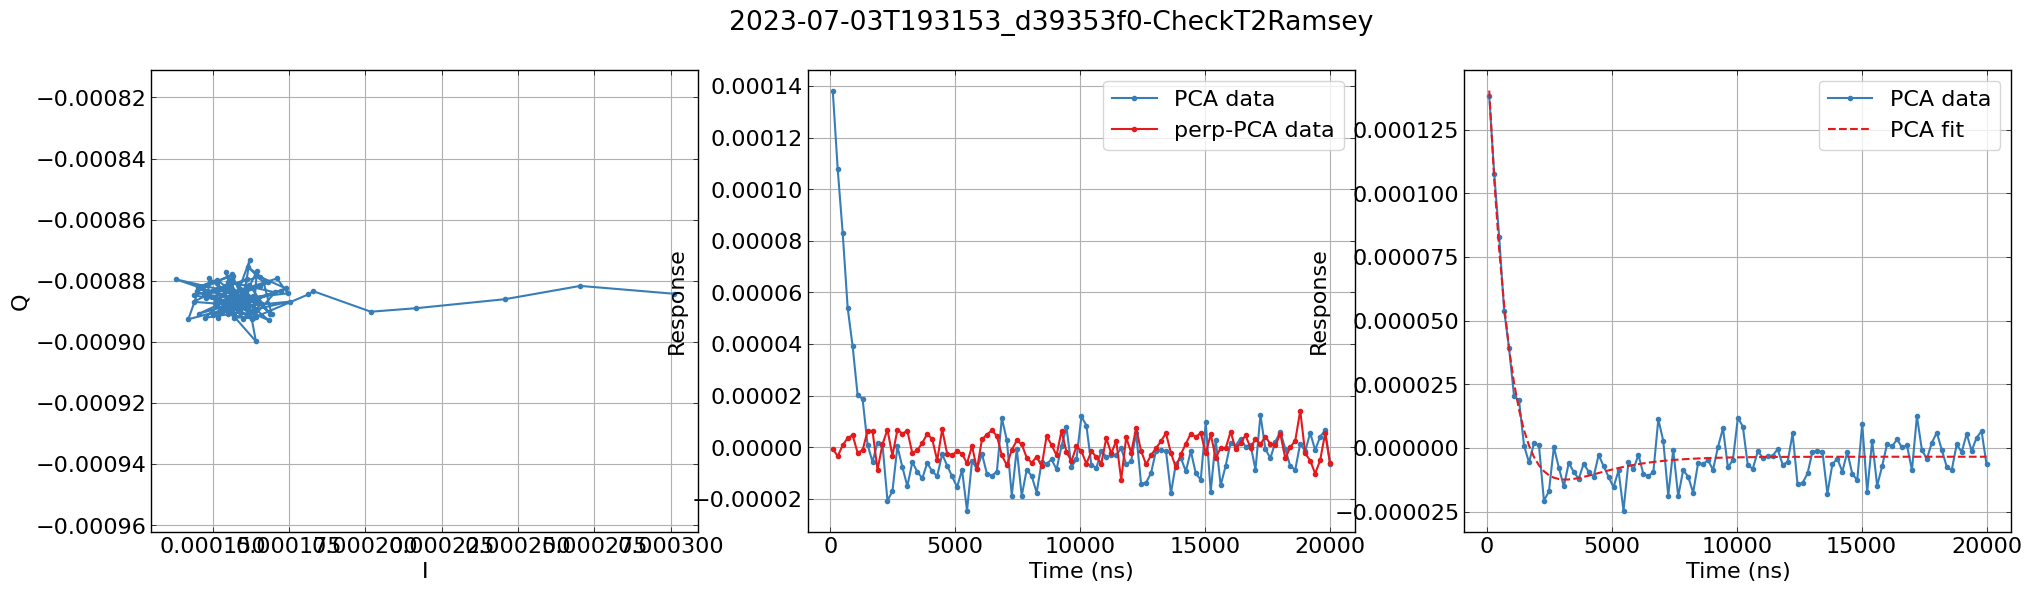

1255.2882579081245


In [30]:
from measurement_codes_ut.experiment.time_domain.check_t2_ramsey import CheckT2Ramsey

exp = CheckT2Ramsey(num_shot=1000, min_duration=100, max_duration=20e3, num_sample=101, hand_detune=0.1e6)
dataset = exp.execute(tdm, note)
print(note.t2_star)

100%|██████████| 51/51 [00:14<00:00,  3.57it/s]


Experiment data saved in D:/data_vault/Matsuura/2023-07-03/2023-07-03T193222_e552d325-CheckT2Echo/


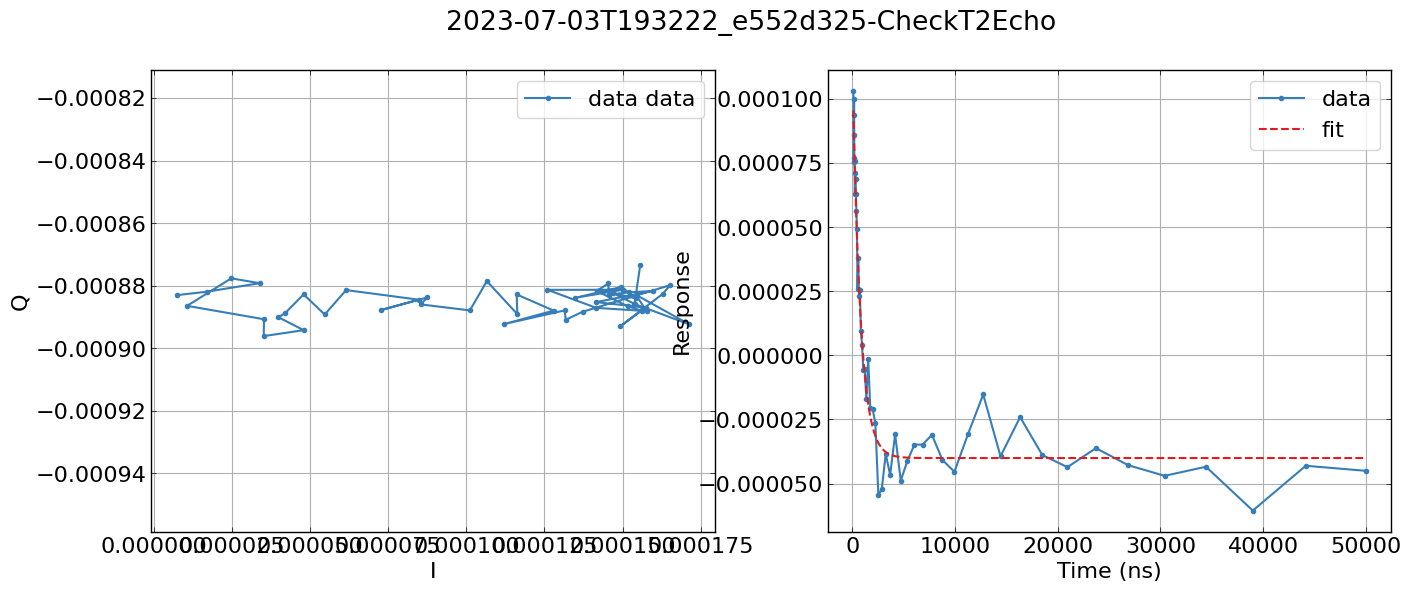

772.9417021039671


In [31]:
from measurement_codes_ut.experiment.time_domain.check_t2_echo import CheckT2Echo

exp = CheckT2Echo(num_shot=1000, min_duration=100, max_duration=50e3, num_sample=51)
dataset = exp.execute(tdm, note)
print(note.t2_echo)